### Example E.5.3. BAYESIAN STUDENT-T REGRESSION from https://openreview.net/pdf?id=HltJfwwfhX

In [1]:
import matplotlib.pyplot as plt # plotting
from matplotlib.ticker import FormatStrFormatter

# Configure matplotlib to use LaTeX for rendering text
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

plt.rc('figure', figsize=(1.3 * 6.4, 1.3 * 4.8))

plt.rc('font', family='serif', size=22)
plt.rc('axes', labelsize=30, titlesize=20, labelpad=20)  # Adjusting axes parameters
plt.rc('xtick', labelsize=25)  # Adjusting xtick parameters
plt.rc('ytick', labelsize=25)  # Adjusting ytick parameters
plt.rc('legend', handlelength=2)  # e.g., shorter lines
plt.rc('lines', markersize=8)  # Replace 10 with your desired size


In [2]:
import pystan
import pandas as pd
import numpy as np
import requests
import sys
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
import rpy2.robjects as ro
import json
import jax
from collections import OrderedDict
import gc
import os
import pickle

from scipy.special import logsumexp

from amis_algorithms import alpha_AMIS_fixed_dof, AMIS_student_fixed_dof, alpha_AMIS_adapted_dof

# import bridgestan

from utils import old_ksd


import pickle
# import tikzplotlib



# from tueplots import bundles
# plt.rcParams.update(bundles.aistats2023())

from experiments_amis import run_AMIS_real_dataset, run_adaptiveAMISrealdataset


# # Load and prepare the dataset
# url = "https://github.com/faosorios/heavy/blob/master/data/creatinine.rda?raw=true"
# with requests.get(url) as resp:
#     with open("creatinine.rda", "wb") as f:
#         f.write(resp.content)

# Load and prepare the dataset
url = "https://github.com/faosorios/heavy/blob/master/data/creatinine.rda?raw=true"
filename = "creatinine.rda"

# Check if the file already exists
if not os.path.exists(filename):
    with requests.get(url) as resp:
        with open(filename, "wb") as f:
            f.write(resp.content)
    print(f"{filename} downloaded.")
else:
    print(f"{filename} already exists.")

# Load RDA file into Python
ro.r['load']("creatinine.rda")
df = pandas2ri.rpy2py_dataframe(ro.r['creatinine'])

data_df = pd.DataFrame(columns=['log_SC', 'log_WT', 'log_140_minus_A', 'log_CR'])

# Apply transformations following https://openreview.net/pdf?id=HltJfwwfhX
data_df['log_SC'] = np.log(df['SC'])
data_df['log_WT'] = np.log(df['WT'])
data_df['log_CR'] = np.log(df['CR'])
data_df['log_140_minus_A'] = np.log(140 - df['Age'])
data_df = data_df.dropna() # remove any rows with NaN values after transformation

# Compile the Stan model
sm = pystan.StanModel(file="./student_reg_model.stan")

# Prepare data for Stan model
data_for_stan = {
    'N': len(data_df),
    'x1': data_df['log_SC'].values.tolist(),
    'x2': data_df['log_WT'].values.tolist(),
    'x3': data_df['log_140_minus_A'].values.tolist(),
    'y': data_df['log_CR'].values.tolist()  # response variable
}

# Save the data dictionary to a JSON file
with open("student_regression_data.json", "w") as f:
    json.dump(data_for_stan, f, indent=4)


# Fit the model and sample from the posterior using NUTS (NUTS paper: https://arxiv.org/abs/1111.4246)
fit = sm.sampling(data=data_for_stan, iter=2, chains=1)

# import pickle
# Save the model and fit to a file
# with open('model_and_fit.pkl', 'wb') as f:
#     pickle.dump({'model': sm, 'fit': fit}, f)


# mcmc_samples = fit.extract()

# stan = "./student_reg_model.stan"
# data = "./student_regression_data.json"


# bridgestan_model = bridgestan.StanModel.from_stan_file(stan, data)

true_log_pdf = fit.log_prob

#  Find the MAP solution
# map_sol = sm.optimizing(data=data_for_stan)
#
# # Retrieve the values, extract the single element from each array, and convert to an ndarray
# map_sol_array = np.array([value.item() for value in map_sol.values()])

# map_sol_list = list(map_sol.values())
# log_dens_at_map, _, hessian_at_map = bridgestan_model.log_density_hessian(theta_unc=map_sol_array, propto=True)

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /Users/nicolabranchini/miniforge3/envs/ais-heavy-tails/lib/R
INFO:rpy2.situation:R library path: 
INFO:rpy2.situation:LD_LIBRARY_PATH: 
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6be3216bb2949d4356187fa264ca25e7 NOW.


creatinine.rda already exists.


In file included from /var/folders/j5/9grhtgg17d5cnz9j926s7tyw0000gn/T/pystan_8uha3_gy/stanfit4anon_model_6be3216bb2949d4356187fa264ca25e7_8048314945282833681.cpp:1242:
In file included from /Users/nicolabranchini/miniforge3/envs/ais-heavy-tails/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/nicolabranchini/miniforge3/envs/ais-heavy-tails/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/nicolabranchini/miniforge3/envs/ais-heavy-tails/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/nicolabranchini/miniforge3/envs/ais-heavy-tails/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/j5/9grhtgg17d5cnz


Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 2 [ 50%]  (Warmup)
Iteration: 2 / 2 [100%]  (Sampling)

 Elapsed Time: 3.1e-05 seconds (Warm-up)
               1e-05 seconds (Sampling)
               4.1e-05 seconds (Total)


 /Users/nicolabranchini/miniforge3/envs/ais-heavy-tails/lib/python3.9/site-packages/pystan/diagnostics.py:217: RuntimeWarning:invalid value encountered in divide


### Running stuff

In [3]:
dim = 4 # Fixed
dof_list = [4]

######### Not used now, useful for ground truth, Laplace initialisation
# mu_initial_proposal_laplace = map_sol_array
#
# assert np.isclose(log_dens_at_map, fit.log_prob(map_sol_list))
#
# # Negative inverse of the Hessian at the MAP solution used as covariance
# cov_laplace = -np.linalg.inv(hessian_at_map)
#
# assert np.all(np.linalg.eigvals(cov_laplace) > 0)



n_iter = 25
nb_runs = 250 # was 150 for good res,


sigmaSq_init = 4

# initt = 'Laplaceinit'

initt = 'Sigmfixedinit'+str(sigmaSq_init)


# list_num_samples = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

# list_num_samples = [x for x in range(5000, 10001, 500)]

list_num_samples_one = [x for x in range(5000, 10001, 500)]
list_num_samples_two = [x for x in range(500, 5000, 500)] # remaining part

list_num_samples_three = [x for x in range(50, 500, 50)] # another remaining part


list_num_samples = list_num_samples_one + list_num_samples_two



### Run with adaptive tail

In [4]:
# # ADAPTIVE
#
# dof_proposal = 3
#
# for num_samples in list_num_samples:
#
#     all_est_Z, ESS, alphaESS, all_dof = run_adaptiveAMISrealdataset(alg=alpha_AMIS_adapted_dof, nb_runs=nb_runs, n_iterations=n_iter, log_pi_tilde=true_log_pdf, dof_proposal=dof_proposal, M=num_samples, d=dim, sigmaSq_init=sigmaSq_init)
#
#     print('done adaptive alpha-AMIS with n_samples', num_samples)
#
#
#     np.save('./results/realdata/all_replicates/adaptiveGPadaptivealphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_allestZ.npy", all_est_Z)
#     np.save('./results/realdata/all_replicates/adaptiveGPadaptivealphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_ESS.npy", ESS)
#     np.save('./results/realdata/all_replicates/adaptiveGPadaptivealphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_alphaESS.npy", alphaESS)
#     np.save('./results/realdata/all_replicates/adaptiveGPadaptivealphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_alldof.npy", all_dof)
#
#     del all_est_Z, ESS, alphaESS, all_dof
#
#     # if done_AMIS:
#     #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_meanZ_baseline.npy", mean_Z_baseline)
#     #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_stdZ_baseline.npy", std_Z_baseline)
#     #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_ESS_baseline.npy", mean_ESS_baseline)
#     #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_ESS_baseline.npy", std_ESS_baseline)
#     #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_alphaESS_baseline.npy", mean_alphaESS_baseline)
#     #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_alphaESS_baseline.npy", std_alphaESS_baseline)
#     #
#     #     del mean_Z_baseline,std_Z_baseline,mean_ESS_baseline,std_ESS_baseline,mean_alphaESS_baseline,std_alphaESS_baseline
#     #
#     # if done_alphaAMIS:
#     #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_Z.npy", mean_Z)
#     #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_Z.npy", std_Z)
#     #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_ESS.npy", mean_ESS)
#     #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_ESS.npy", std_ESS)
#     #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_alphaESS.npy", mean_alphaESS)
#     #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_alphaESS.npy", std_alphaESS)
#     #
#     #     del mean_Z,std_Z,mean_ESS,std_ESS,mean_alphaESS,std_alphaESS
#
#     gc.collect()


### Run AMIS and fixed dof alphaAMIS

In [5]:
# # FIXED DOF
# for dof_proposal in [4]:
#
#
#     for num_samples in list_num_samples:
#
#         done_AMIS = False
#         done_alphaAMIS = False
#
#         # if not os.path.exists('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_meanZ_baseline.npy"):
#
#         all_est_Z_baseline, ESS_baseline, alphaESS_baseline  = run_AMIS_real_dataset(alg=AMIS_student_fixed_dof, nb_runs=nb_runs, n_iterations=n_iter, log_pi_tilde=true_log_pdf, dof_proposal=dof_proposal, M=num_samples, d=dim, sigmaSq_init=sigmaSq_init)
#
#         print('done AMIS with n_samples', num_samples)
#             # done_AMIS = True
#
#         # if not os.path.exists('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_Z.npy"):
#
#         all_est_Z, ESS, alphaESS = run_AMIS_real_dataset(alg=alpha_AMIS_fixed_dof, nb_runs=nb_runs, n_iterations=n_iter, log_pi_tilde=true_log_pdf, dof_proposal=dof_proposal, M=num_samples, d=dim, sigmaSq_init=sigmaSq_init)
#
#         print('done alpha-AMIS with n_samples', num_samples)
#
#             # done_alphaAMIS = True
#
#         np.save('./results/realdata/all_replicates/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_allestZ_baseline.npy", all_est_Z_baseline)
#         np.save('./results/realdata/all_replicates/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_ESS_baseline.npy", ESS_baseline)
#         np.save('./results/realdata/all_replicates/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_alphaESS_baseline.npy", alphaESS_baseline)
#
#         np.save('./results/realdata/all_replicates/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_allestZ.npy", all_est_Z)
#         np.save('./results/realdata/all_replicates/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_ESS.npy", ESS)
#         np.save('./results/realdata/all_replicates/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_alphaESS.npy", alphaESS)
#
#         del all_est_Z_baseline, ESS_baseline, alphaESS_baseline, all_est_Z, ESS, alphaESS
#
#         # if done_AMIS:
#         #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_meanZ_baseline.npy", mean_Z_baseline)
#         #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_stdZ_baseline.npy", std_Z_baseline)
#         #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_ESS_baseline.npy", mean_ESS_baseline)
#         #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_ESS_baseline.npy", std_ESS_baseline)
#         #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_alphaESS_baseline.npy", mean_alphaESS_baseline)
#         #     np.save('./results/realdata/AMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_alphaESS_baseline.npy", std_alphaESS_baseline)
#         #
#         #     del mean_Z_baseline,std_Z_baseline,mean_ESS_baseline,std_ESS_baseline,mean_alphaESS_baseline,std_alphaESS_baseline
#         #
#         # if done_alphaAMIS:
#         #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_Z.npy", mean_Z)
#         #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_Z.npy", std_Z)
#         #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_ESS.npy", mean_ESS)
#         #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_ESS.npy", std_ESS)
#         #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_alphaESS.npy", mean_alphaESS)
#         #     np.save('./results/realdata/alphaAMIS/' + initt + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_alphaESS.npy", std_alphaESS)
#         #
#         #     del mean_Z,std_Z,mean_ESS,std_ESS,mean_alphaESS,std_alphaESS
#
#         gc.collect()
#
#     # Last key is the log probability, which we don't want
#     # exclude_key = "lp__"
#     # mcmc_samples = OrderedDict((k, v) for k, v in mcmc_samples.items() if k != exclude_key)
#     # mcmc_samples_array = np.vstack(list(mcmc_samples.values())).T

### Loading data for plotting


In [6]:
# load
def load_all_npy_files(directory):
    """
    Load all .npy files from a specified directory.

    Parameters:
    - directory (str): Path to the directory containing .npy files.

    Returns:
    - A dictionary with filenames as keys and loaded numpy arrays as values.
    """
    files = [f for f in os.listdir(directory) if f.endswith('.npy')]
    data = {}

    for f in files:
        full_path = os.path.join(directory, f)
        data[f] = np.load(full_path)

    return data

# Usage
directory_path = './results/realdata/all_replicates/AMIS'
loaded_data = load_all_npy_files(directory_path)

In [7]:
directory_path_alphaAMIS = './results/realdata/all_replicates/alphaAMIS/'
loaded_data_alphaAMIS = load_all_npy_files(directory_path_alphaAMIS)

In [8]:
directory_path_adaptivealphaAMIS = './results/realdata/all_replicates/adaptiveGPadaptivealphaAMIS/'
loaded_data_adaptivealphaAMIS = load_all_npy_files(directory_path_adaptivealphaAMIS)


In [9]:
dictionaries_data = [loaded_data, loaded_data_alphaAMIS, loaded_data_adaptivealphaAMIS]

set_keys_metrics, set_dofs, set_initialisation, set_nbruns, set_numsamples = set(), set(), set(), set(), set()

# First create dict
for i, data in enumerate(dictionaries_data):
    for key, _ in data.items():

        parts = key.replace(".npy", "").split("_")
        cleaned_parts = list(filter(lambda item: item != '', parts))

        # print(cleaned_parts)

        initialisation = cleaned_parts[0]
        numsamples = cleaned_parts[1]
        metric = cleaned_parts[-1] if (i==1) or (i ==2) else cleaned_parts[-2]

        # if metric == 'alldof':
        #     continue

        dof = cleaned_parts[3]
        nbruns = cleaned_parts[5]

        set_keys_metrics.add(metric)
        set_dofs.add(dof)
        set_initialisation.add(initialisation)
        set_numsamples.add(numsamples)
        set_nbruns.add(nbruns)

results_final_baseline, results_final_ours, results_final_ours_adapted = {}, {}, {}

set_keys_metrics_no_dofs = set_keys_metrics.copy()
set_keys_metrics_no_dofs.remove('alldof')

for metric in set_keys_metrics_no_dofs:
    results_final_baseline[metric], results_final_ours[metric] = {}, {}
    for initt in set_initialisation:
        results_final_baseline[metric][initt], results_final_ours[metric][initt] = {}, {}
        for dof in set_dofs:
            results_final_baseline[metric][initt][dof], results_final_ours[metric][initt][dof] = {}, {}
            for nbruns in set_nbruns:
                results_final_baseline[metric][initt][dof][nbruns], results_final_ours[metric][initt][dof][nbruns] = {}, {}
                for numsamples in set_numsamples:
                    results_final_baseline[metric][initt][dof][nbruns][numsamples], results_final_ours[metric][initt][dof][nbruns][numsamples]= None, None

for metric in set_keys_metrics:
    results_final_ours_adapted[metric] = {}
    for initt in set_initialisation:
        results_final_ours_adapted[metric][initt] = {}
        for dof in set_dofs:
            results_final_ours_adapted[metric][initt][dof] = {}
            for nbruns in set_nbruns:
                results_final_ours_adapted[metric][initt][dof][nbruns] = {}
                for numsamples in set_numsamples:
                    results_final_ours_adapted[metric][initt][dof][nbruns][numsamples] = None

for i, data in enumerate(dictionaries_data):
    for key, value in data.items():

        parts = key.replace(".npy", "").split("_")
        cleaned_parts = list(filter(lambda item: item != '', parts))

        initialisation = cleaned_parts[0]
        numsamples = cleaned_parts[1]
        metric = cleaned_parts[-1] if (i==1) or (i ==2) else cleaned_parts[-2]

        dof = cleaned_parts[3]
        nbruns = cleaned_parts[5]

        if i == 0:
            results_final_baseline[metric][initialisation][dof][nbruns][numsamples] = value
        elif i == 1:
            results_final_ours[metric][initialisation][dof][nbruns][numsamples] = value
        else: # i == 2
            results_final_ours_adapted[metric][initialisation][dof][nbruns][numsamples] = value


# # Cleaning for old data
# # First create dict
# for i, data in enumerate(dictionaries_data):
#     for key, _ in data.items():
#
#         parts = key.replace(".npy", "").replace("niter","").replace("25","").split("_")
#         cleaned_parts = list(filter(lambda item: item != '', parts))
#
#         # Cleaning
#         if 'ESS' in cleaned_parts:
#             idx = cleaned_parts.index('ESS')
#             cleaned_parts[idx-1]+= 'ESS'
#             cleaned_parts.remove('ESS')
#         if 'alphaESS' in cleaned_parts:
#             idx = cleaned_parts.index('alphaESS')
#             cleaned_parts[idx-1]+= 'alphaESS'
#             cleaned_parts.remove('alphaESS')
#         if 'Z' in cleaned_parts:
#             idx = cleaned_parts.index('Z')
#             cleaned_parts[idx-1]+= 'Z'
#             cleaned_parts.remove('Z')
#
#         initialisation = cleaned_parts[0]
#         numsamples = cleaned_parts[1]
#         metric = cleaned_parts[-1] if i==1 else cleaned_parts[-2]
#         dof = cleaned_parts[3]
#         nbruns = cleaned_parts[5]
#
#         set_keys_metrics.add(metric)
#         set_dofs.add(dof)
#         set_initialisation.add(initialisation)
#         set_numsamples.add(numsamples)
#         set_nbruns.add(nbruns)
#
# results_final_baseline, results_final_ours= {}, {}
#
# for metric in set_keys_metrics:
#     results_final_baseline[metric], results_final_ours[metric] = {}, {}
#     for initt in set_initialisation:
#         results_final_baseline[metric][initt], results_final_ours[metric][initt] = {}, {}
#         for dof in set_dofs:
#             results_final_baseline[metric][initt][dof], results_final_ours[metric][initt][dof] = {}, {}
#             for nbruns in set_nbruns:
#                 results_final_baseline[metric][initt][dof][nbruns], results_final_ours[metric][initt][dof][nbruns] = {}, {}
#                 for numsamples in set_numsamples:
#                     results_final_baseline[metric][initt][dof][nbruns][numsamples], results_final_ours[metric][initt][dof][nbruns][numsamples] = [], []
#
# for i, data in enumerate(dictionaries_data):
#     for key, value in data.items():
#
#         parts = key.replace(".npy", "").replace("niter","").replace("25","").split("_")
#         cleaned_parts = list(filter(lambda item: item != '', parts))
#
#         # Cleaning
#         if 'ESS' in cleaned_parts:
#             idx = cleaned_parts.index('ESS')
#             cleaned_parts[idx-1]+= 'ESS'
#             cleaned_parts.remove('ESS')
#         if 'alphaESS' in cleaned_parts:
#             idx = cleaned_parts.index('alphaESS')
#             cleaned_parts[idx-1]+= 'alphaESS'
#             cleaned_parts.remove('alphaESS')
#         if 'Z' in cleaned_parts:
#             idx = cleaned_parts.index('Z')
#             cleaned_parts[idx-1]+= 'Z'
#             cleaned_parts.remove('Z')
#
#         initialisation = cleaned_parts[0]
#         numsamples = cleaned_parts[1]
#         metric = cleaned_parts[-1] if i==1 else cleaned_parts[-2]
#         dof = cleaned_parts[3]
#         nbruns = cleaned_parts[5]
#
#         if not value.shape == ():
#             value = value[-1] # keeping only last value of iteration number
#
#         if i == 0:
#             # print(value)
#             # print(value.item())
#             # print(value.shape)
#             results_final_baseline[metric][initialisation][dof][nbruns][numsamples].append(value.item())
#         else: #(i == 1)
#             results_final_ours[metric][initialisation][dof][nbruns][numsamples].append(value.item())

### DOF evolution

In [10]:
# runs_str = str(nb_runs)
# sorted_numsamples = sorted(
#     [
#         int(key)
#         for key, value in results_final_ours_adapted['alldof']['Sigmfixedinit4'][str(dof_proposal)][runs_str].items()
#         if value is not None
#     ]
# )
# sorted_numsamples_str = [str(num) for num in sorted_numsamples]
#
# # sorted_values = []
# for key in sorted_numsamples_str:
#     mean_value = results_final_ours_adapted['alldof']['Sigmfixedinit4'][str(dof_proposal)][runs_str][key].mean(0)
#     std_value = results_final_ours_adapted['alldof']['Sigmfixedinit4'][str(dof_proposal)][runs_str][key].std(0)
#     # sorted_values.append(mean_value)
#
#     plt.title('Dof evolution with n samples' + key)
#     plt.plot(np.arange(len(mean_value)), mean_value, label='mean')
#     plt.fill_between(np.arange(len(mean_value)), mean_value - 1.96 * std_value, mean_value + 1.96 * std_value, alpha=0.1)
#     plt.show()
#
#
# # sorted_values = np.asarray(sorted_values)


In [11]:
# Function to manage colors per marker type
def get_color_for_marker(marker, marker_to_color, color_cycle):
    if marker not in marker_to_color:
        try:
            new_color = next(color_cycle)
        except StopIteration:
            # Restart the color cycle if it has ended
            color_cycle = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
            new_color = next(color_cycle)
        marker_to_color[marker] = new_color
    return marker_to_color[marker]


# Prepare the color cycle and marker-color mapping
color_cycle = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
marker_to_color = {}


### Alpha ESS

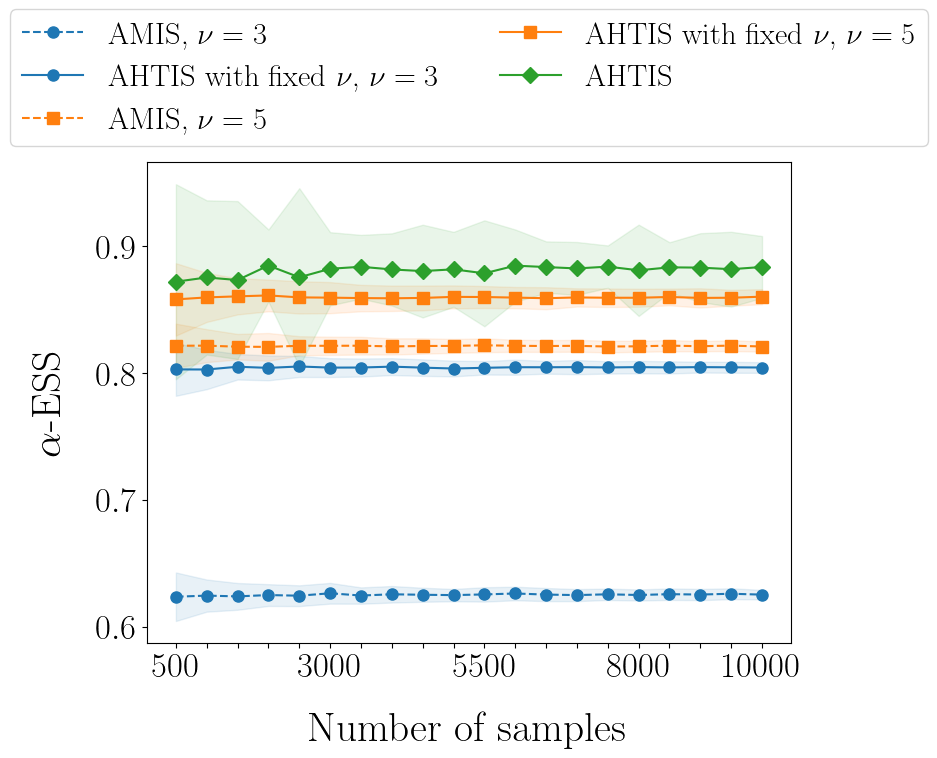

In [12]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure()
fig.set_size_inches((1.3 * 6.4, 1.3 * 4.8))

# plt.rc('font', family='serif', size=18)
# plt.rc('axes', labelsize=25, titlesize=20, labelpad=20)  # Adjusting axes parameters
# plt.rc('xtick', labelsize=20)  # Adjusting xtick parameters
# plt.rc('ytick', labelsize=20)  # Adjusting ytick parameters
# plt.rc('legend', fontsize=12, loc='lower left')  # Adjusting legend parameters
# plt.rc('legend', handlelength=1)  # e.g., shorter lines


for dof in ['3','5']:

    sorted_numsamples_baseline = sorted(
        [
            int(key)
            for key, value in results_final_baseline['alphaESS']['Sigmfixedinit4'][dof][str(nb_runs)].items()
            if value is not None
        ]
    )
    sorted_numsamples_baseline_str = [str(num) for num in sorted_numsamples_baseline]

    # Step 2: Iterate through the sorted keys and get the corresponding values
    # all_replicates_baseline = np.asarray([ results_final_baseline['alphaESS']['Sigmfixedinit4'][dof][str(nb_runs)][key].mean() for key in sorted_numsamples_baseline_str])
    sorted_values_baseline = []
    for key in sorted_numsamples_baseline_str:
            mean_value = results_final_baseline['alphaESS']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].mean()
            sorted_values_baseline.append(mean_value)

    sorted_values_baseline = np.asarray(sorted_values_baseline)

    sorted_values_baseline_std = []
    for key in sorted_numsamples_baseline_str:
            std_val = results_final_baseline['alphaESS']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].std()
            sorted_values_baseline_std.append(std_val)

    sorted_values_baseline_std = np.asarray(sorted_values_baseline_std)



    sorted_numsamples_ours = sorted(
        [
            int(key)
            for key, value in results_final_ours['alphaESS']['Sigmfixedinit4'][dof][str(nb_runs)].items()
            if value is not None
        ]
    )
    sorted_numsamples_ours_str = [str(num) for num in sorted_numsamples_ours]

    # Step 2: Iterate through the sorted keys and get the corresponding values

    sorted_values_ours = []
    for key in sorted_numsamples_ours_str:
            mean_value = results_final_ours['alphaESS']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].mean()
            sorted_values_ours.append(mean_value)

    sorted_values_ours = np.asarray(sorted_values_ours)

    sorted_values_ours_std = []
    for key in sorted_numsamples_ours_str:
            std_val = results_final_ours['alphaESS']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].std()
            sorted_values_ours_std.append(std_val)

    sorted_values_ours_std = np.asarray(sorted_values_ours_std)

    if dof == '3':
        marker = 'o'
    elif dof == '4':
        marker = 'v'
    else:
        marker = 's'

    color = get_color_for_marker(marker, marker_to_color, color_cycle)
    plt.plot(sorted_numsamples_baseline,  sorted_values_baseline,  marker=marker, linestyle='--', label=r'AMIS, $\nu={}$'.format(dof), color=color)
    plt.plot(sorted_numsamples_ours,  sorted_values_ours, marker=marker, linestyle='-', label=r'AHTIS with fixed $\nu$, $\nu={}$'.format(dof), color=color)

    plt.fill_between(sorted_numsamples_baseline, sorted_values_baseline - sorted_values_baseline_std, sorted_values_baseline + sorted_values_baseline_std, alpha=0.1, color=color)
    plt.fill_between(sorted_numsamples_ours, sorted_values_ours - sorted_values_ours_std, sorted_values_ours + sorted_values_ours_std, alpha=0.1, color=color)


# Adapted dof (recall it is stored in a fixed dof = 3 for now)
sorted_numsamples_ours_adapted = sorted(
    [
        int(key)
        for key, value in results_final_ours_adapted['alphaESS']['Sigmfixedinit4']['3'][str(nb_runs)].items()
        if value is not None
    ]
)

sorted_numsamples_ours_adapted_str = [str(num) for num in sorted_numsamples_ours_adapted]

# Step 2: Iterate through the sorted keys and get the corresponding values

sorted_values_ours_adapted = []
for key in sorted_numsamples_ours_adapted_str:
        mean_value = results_final_ours_adapted['alphaESS']['Sigmfixedinit4']['3'][str(nb_runs)][key][:,-1].mean()
        sorted_values_ours_adapted.append(mean_value)

sorted_values_ours_adapted = np.asarray(sorted_values_ours_adapted)

sorted_values_ours_adapted_std = []
for key in sorted_numsamples_ours_adapted_str:
        std_val = results_final_ours_adapted['alphaESS']['Sigmfixedinit4']['3'][str(nb_runs)][key][:,-1].std()
        sorted_values_ours_adapted_std.append(std_val)

sorted_values_ours_adapted_std = np.asarray(sorted_values_ours_adapted_std)

marker = 'D'
color = get_color_for_marker(marker, marker_to_color, color_cycle)
plt.plot(sorted_numsamples_ours_adapted,  sorted_values_ours_adapted,  marker=marker, linestyle='-', label='AHTIS ', color=color)

plt.fill_between(sorted_numsamples_ours_adapted, sorted_values_ours_adapted - sorted_values_ours_adapted_std, sorted_values_ours_adapted +  sorted_values_ours_adapted_std, alpha=0.1, color=color)

# Access the current Axes instance:
ax = plt.gca()

# Using MultipleLocator to place a tick every 0.5 units
ax.xaxis.set_major_locator(MultipleLocator(500))

plt.xticks(sorted_numsamples_ours_adapted)
# plt.xticks(rotation=90)

# plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')  # Set y-axis to log scale

# plt.grid(axis='y')  # showing both major and minor grid lines

# Get current x-tick labels
xticks_locs, xticks_old = plt.xticks()

# Create new x-tick labels
new_xticks = [''] * len(xticks_locs)
for i, loc in enumerate(xticks_locs):
    # Show every 5th, the first, and the last tick label
    if i % 5 == 0 or i == 0 or i == len(xticks_locs)-1:
        new_xticks[i] = str(int(loc))
plt.xticks(xticks_locs, new_xticks)


plt.xlabel('Number of samples')
plt.ylabel(r'$\alpha$-ESS')
# plt.axhline(y=truth, color='r', linestyle='solid', lw=2, label=r'AMIS with $10^5$ samples (dof=5)')
# plt.tight_layout()
# plt.yscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
plt.savefig('./results/creatinine_alphaESS.pdf',bbox_inches='tight')


In [13]:
# load ground truth
directory_path_old = './results/realdata/AMIS'
loaded_dataOld = load_all_npy_files(directory_path_old)

set_keys_metricsOld, set_dofsOld, set_initialisationOld, set_nbrunsOld, set_numsamplesOld = set(), set(), set(), set(), set()

for key, _ in loaded_dataOld.items():

    parts = key.replace(".npy", "").replace("niter","").replace("25","").split("_")
    cleaned_parts = list(filter(lambda item: item != '', parts))

    # Cleaning
    if 'ESS' in cleaned_parts:
        idx = cleaned_parts.index('ESS')
        cleaned_parts[idx-1]+= 'ESS'
        cleaned_parts.remove('ESS')
    if 'alphaESS' in cleaned_parts:
        idx = cleaned_parts.index('alphaESS')
        cleaned_parts[idx-1]+= 'alphaESS'
        cleaned_parts.remove('alphaESS')
    if 'Z' in cleaned_parts:
        idx = cleaned_parts.index('Z')
        cleaned_parts[idx-1]+= 'Z'
        cleaned_parts.remove('Z')

    initialisation = cleaned_parts[0]
    numsamples = cleaned_parts[1]
    metric = cleaned_parts[-2]
    dof = cleaned_parts[3]
    nbruns = cleaned_parts[5]


    set_keys_metricsOld.add(metric)
    set_dofsOld.add(dof)
    set_initialisationOld.add(initialisation)
    set_numsamplesOld.add(numsamples)
    set_nbrunsOld.add(nbruns)


results_old_baseline = {}
for metric in set_keys_metricsOld:
    results_old_baseline[metric] = {}
    for initt in set_initialisationOld:
        results_old_baseline[metric][initt] = {}
        for dof in set_dofsOld:
            results_old_baseline[metric][initt][dof] = {}
            for nbruns in set_nbrunsOld:
                results_old_baseline[metric][initt][dof][nbruns] = {}
                for numsamples in set_numsamplesOld:
                    results_old_baseline[metric][initt][dof][nbruns][numsamples] = None

for key, value in loaded_dataOld.items():

    parts = key.replace(".npy", "").replace("niter","").replace("25","").split("_")
    cleaned_parts = list(filter(lambda item: item != '', parts))

    # Cleaning
    if 'ESS' in cleaned_parts:
        idx = cleaned_parts.index('ESS')
        cleaned_parts[idx-1]+= 'ESS'
        cleaned_parts.remove('ESS')
    if 'alphaESS' in cleaned_parts:
        idx = cleaned_parts.index('alphaESS')
        cleaned_parts[idx-1]+= 'alphaESS'
        cleaned_parts.remove('alphaESS')
    if 'Z' in cleaned_parts:
        idx = cleaned_parts.index('Z')
        cleaned_parts[idx-1]+= 'Z'
        cleaned_parts.remove('Z')

    initialisation = cleaned_parts[0]
    numsamples = cleaned_parts[1]
    metric = cleaned_parts[-2]

    dof = cleaned_parts[3]
    nbruns = cleaned_parts[5]

    results_old_baseline[metric][initialisation][dof][nbruns][numsamples] = value



In [14]:
# from matplotlib.ticker import MultipleLocator
#
# for dof in [3,5]:
#
#     sorted_numsamples_baseline = sorted(
#         [
#             int(key)
#             for key, value in results_final_baseline['ESS']['Sigmfixedinit4'][dof][str(nb_runs)].items()
#             if value is not None
#         ]
#     )
#     sorted_numsamples_baseline_str = [str(num) for num in sorted_numsamples_baseline]
#
#     # Step 2: Iterate through the sorted keys and get the corresponding values
#     # all_replicates_baseline = np.asarray([ results_final_baseline['alphaESS']['Sigmfixedinit4'][dof]['500'][key].mean() for key in sorted_numsamples_baseline_str])
#     sorted_values_baseline = []
#     for key in sorted_numsamples_baseline_str:
#             mean_value = results_final_baseline['ESS']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].mean()
#             sorted_values_baseline.append(mean_value)
#
#     sorted_values_baseline = np.asarray(sorted_values_baseline)
#
#     sorted_values_baseline_std = []
#     for key in sorted_numsamples_baseline_str:
#             std_val = results_final_baseline['ESS']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].std()
#             sorted_values_baseline_std.append(std_val)
#
#     sorted_values_baseline_std = np.asarray(sorted_values_baseline_std)
#
#
#
#     sorted_numsamples_ours = sorted(
#         [
#             int(key)
#             for key, value in results_final_ours['ESS']['Sigmfixedinit4'][dof][str(nb_runs)].items()
#             if value is not None
#         ]
#     )
#     sorted_numsamples_ours_str = [str(num) for num in sorted_numsamples_ours]
#
#     # Step 2: Iterate through the sorted keys and get the corresponding values
#
#     sorted_values_ours = []
#     for key in sorted_numsamples_ours_str:
#             mean_value = results_final_ours['ESS']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].mean()
#             sorted_values_ours.append(mean_value)
#
#     sorted_values_ours = np.asarray(sorted_values_ours)
#
#     sorted_values_ours_std = []
#     for key in sorted_numsamples_ours_str:
#             std_val = results_final_ours['ESS']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].std()
#             sorted_values_ours_std.append(std_val)
#
#     sorted_values_ours_std = np.asarray(sorted_values_ours_std)
#
#     if dof == '3':
#         marker = 'o'
#     elif dof == '4':
#         marker = 'x'
#     else:
#         marker = 's'
#
#     plt.plot(sorted_numsamples_baseline,  sorted_values_baseline,  marker=marker, linestyle='--', label=r'AMIS $(\nu={})$'.format(dof))
#     plt.plot(sorted_numsamples_ours,  sorted_values_ours, marker=marker, linestyle='-', label=r'escort AMIS  $(\nu={})$'.format(dof))
#
#     plt.fill_between(sorted_numsamples_baseline, sorted_values_baseline - 1.96 * sorted_values_baseline_std, sorted_values_baseline + 1.96 * sorted_values_baseline_std, alpha=0.1)
#     plt.fill_between(sorted_numsamples_ours, sorted_values_ours - 1.96 * sorted_values_ours_std, sorted_values_ours + 1.96 * sorted_values_ours_std, alpha=0.1)
#
#
# # Adapted dof (recall it is stored in a fixed dof = 3 for now)
# sorted_numsamples_ours_adapted = sorted(
#     [
#         int(key)
#         for key, value in results_final_ours_adapted['ESS']['Sigmfixedinit4']['3']['500'].items()
#         if value is not None
#     ]
# )
#
# sorted_numsamples_ours_adapted_str = [str(num) for num in sorted_numsamples_ours_adapted]
#
# # Step 2: Iterate through the sorted keys and get the corresponding values
#
# sorted_values_ours_adapted = []
# for key in sorted_numsamples_ours_adapted_str:
#         mean_value = results_final_ours_adapted['ESS']['Sigmfixedinit4']['3']['500'][key][:,-1].mean()
#         sorted_values_ours_adapted.append(mean_value)
#
# sorted_values_ours_adapted = np.asarray(sorted_values_ours_adapted)
#
# sorted_values_ours_adapted_std = []
# for key in sorted_numsamples_ours_adapted_str:
#         std_val = results_final_ours_adapted['ESS']['Sigmfixedinit4']['3']['500'][key][:,-1].std()
#         sorted_values_ours_adapted_std.append(std_val)
#
# sorted_values_ours_adapted_std = np.asarray(sorted_values_ours_adapted_std)
#
# plt.plot(sorted_numsamples_ours_adapted,  sorted_values_ours_adapted,  marker='D', linestyle='-.', label='adaptive escort AMIS ')
#
# plt.fill_between(sorted_numsamples_ours_adapted, sorted_values_ours_adapted - 1.96 * sorted_values_ours_adapted_std, sorted_values_ours_adapted + 1.96 * sorted_values_ours_adapted_std, alpha=0.1)
#
# # Access the current Axes instance:
# ax = plt.gca()
#
# # Using MultipleLocator to place a tick every 0.5 units
# ax.xaxis.set_major_locator(MultipleLocator(500))
# plt.xticks(rotation=90)
#
#
# plt.xlabel('Number of samples')
# plt.ylabel(r'ESS')
# # plt.axhline(y=truth, color='r', linestyle='solid', lw=2, label=r'AMIS with $10^5$ samples (dof=5)')
# plt.tight_layout()
# plt.legend()
# plt.savefig('./results/creatinine_ESS.pdf',bbox_inches='tight')

In [15]:
# for dof in ['3','4','5']:
#
#     sorted_numsamples_baseline = sorted(
#         [
#             int(key)
#             for key, value in results_final_baseline['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)].items()
#             if value is not None
#         ]
#     )
#     sorted_numsamples_baseline_str = [str(num) for num in sorted_numsamples_baseline]
#
#     # Best DOF it seems
#     if dof == '5':
#         truth_key = '100000'
#         truth_value = results_old_baseline['meanZ']['Laplaceinit'][dof]['1000'][truth_key]
#
#     # Step 2: Iterate through the sorted keys and get the corresponding values
#     sorted_values_baseline = [ results_final_baseline['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].mean() for key in sorted_numsamples_baseline_str]
#
#     sorted_values_baseline_std = [ results_final_baseline['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].std() for key in sorted_numsamples_baseline_str]
#
#
#     sorted_numsamples_ours = sorted(
#         [
#             int(key)
#             for key, value in results_final_ours['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)].items()
#             if value is not None
#         ]
#     )
#
#     sorted_numsamples_str = [str(num) for num in sorted_numsamples_ours] # should be the same as baseline right ?
#
#     # Step 2: Iterate through the sorted keys and get the corresponding values
#     sorted_values_ours = [ results_final_ours['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].mean() for key in sorted_numsamples_str]
#     sorted_values_ours_std = [ results_final_ours['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1].std() for key in sorted_numsamples_str]
#
#
#     sorted_values_baseline, sorted_values_ours, sorted_values_baseline_std, sorted_values_ours_std = np.array(sorted_values_baseline), np.array(sorted_values_ours), np.array(sorted_values_baseline_std), np.array(sorted_values_ours_std)
#
#     # if dof == '5':
#     plt.plot(sorted_numsamples_baseline,  sorted_values_baseline, label='AMIS (\nu={})'.format(dof))
#     plt.plot(sorted_numsamples_ours,  sorted_values_ours, label='escort AMIS  (\nu={})'.format(dof))
#
#     plt.fill_between(sorted_numsamples_baseline, sorted_values_baseline -   sorted_values_baseline_std, sorted_values_baseline +   sorted_values_baseline_std, alpha=0.1)
#     plt.fill_between(sorted_numsamples_ours, sorted_values_ours -   sorted_values_ours_std, sorted_values_ours +   sorted_values_ours_std, alpha=0.1)
#
#
#
# plt.axhline(y=truth_value, color='r', linestyle='solid', lw=2, label='Estimated true value (with $10^5$ samples)')
# plt.xlabel('Number of samples')
# plt.ylabel(r'$\hat{Z} value$')
# plt.tight_layout()
# plt.yscale('log')
# plt.legend()
# plt.savefig('./results/creatinine_meanZ.pdf',bbox_inches='tight')


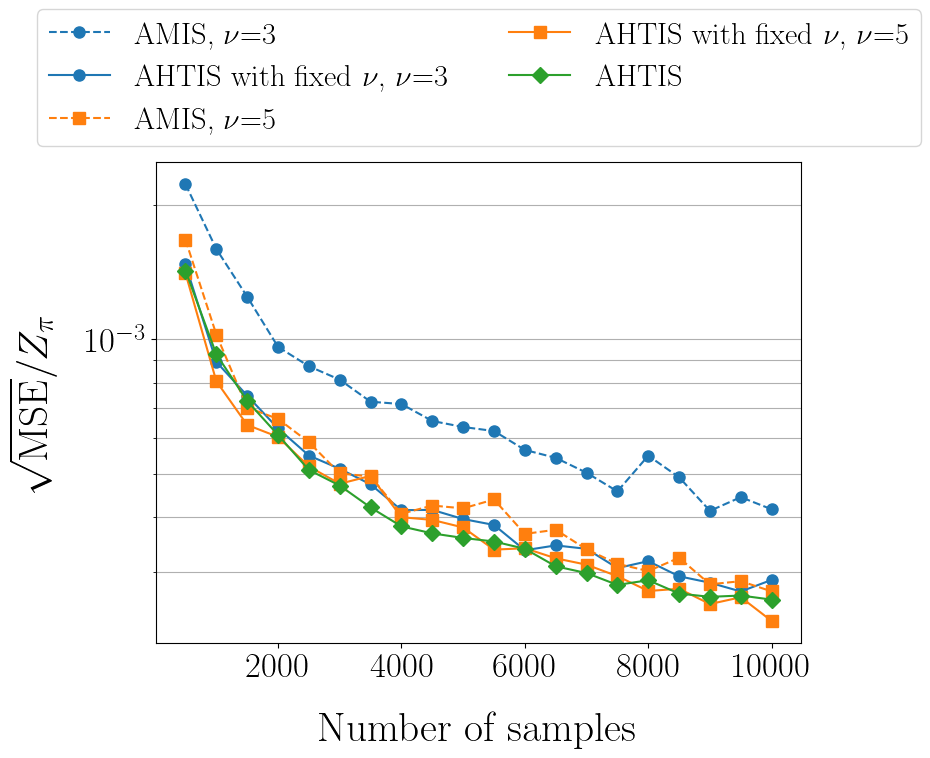

In [16]:

fig = plt.figure()
fig.set_size_inches((1.3 * 6.4, 1.3 * 4.8))

# Best DOF it seems
truth_key = '100000'
truth_value = results_old_baseline['meanZ']['Laplaceinit']['5']['1000'][truth_key]

for dof in ['3','5']:

    sorted_numsamples_baseline = sorted(
        [
            int(key)
            for key, value in results_final_baseline['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)].items()
            if value is not None
        ]
    )
    sorted_numsamples_baseline_str = [str(num) for num in sorted_numsamples_baseline]

    sorted_numsamples_ours = sorted(
        [
            int(key)
            for key, value in results_final_ours['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)].items()
            if value is not None
        ]
    )

    sorted_numsamples_str = [str(num) for num in sorted_numsamples_ours] # should be the same as baseline right ?



    # Step 2: Iterate through the sorted keys and get the corresponding values
    sorted_values_baseline = [results_final_baseline['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1] for key in sorted_numsamples_baseline_str]
    sorted_values_ours = [results_final_ours['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1] for key in sorted_numsamples_str]

    # Calculating the MSE and square root of the relative MSE for baseline and our algorithm
    mse_baseline = [(np.mean((vals - truth_value) ** 2)) for vals in sorted_values_baseline]
    mse_ours = [(np.mean((vals - truth_value) ** 2)) for vals in sorted_values_ours]

    sqrt_rel_mse_baseline = np.sqrt(np.array(mse_baseline) / truth_value)
    sqrt_rel_mse_ours = np.sqrt(np.array(mse_ours) / truth_value)


    if dof == '3':
        marker = 'o'
    elif dof == '4':
        marker = 'v'
    else:
        marker = 's'

    color = get_color_for_marker(marker, marker_to_color, color_cycle)
    # Plotting
    plt.plot(sorted_numsamples_baseline, sqrt_rel_mse_baseline, label=r'AMIS, $\nu$={}'.format(dof), marker=marker, linestyle='--', color=color)
    plt.plot(sorted_numsamples_ours, sqrt_rel_mse_ours, label=r'AHTIS with fixed $\nu$, $\nu$={}'.format(dof), marker=marker, color=color)


sorted_values_ours_adapted = [results_final_ours_adapted['allestZ']['Sigmfixedinit4']['3'][str(nb_runs)][key][:,-1] for key in sorted_numsamples_baseline_str] # should be the same nsamples anyway

mse_ours_adapted = [(np.mean((vals - truth_value) ** 2)) for vals in sorted_values_ours_adapted]

sqrt_rel_mse_ours_adapted = np.sqrt(np.array(mse_ours_adapted) / truth_value)

marker = 'D'
color = get_color_for_marker(marker, marker_to_color, color_cycle)
plt.plot(sorted_numsamples_baseline, sqrt_rel_mse_ours_adapted, label='AHTIS', marker=marker, color=color)


# # Get current y-limits
# ymin, ymax = plt.ylim()
#
# # Get the current axis
# ax = plt.gca()
#
# # Define a function to format the tick labels in scientific notation
# def format_func(value, tick_number):
#     return f"{value:.1e}"
#
# # Apply the function as a formatter for the major and minor y-ticks
# ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_func))
# ax.yaxis.set_minor_formatter(mticker.FuncFormatter(format_func))
#
# # Making sure minor ticks are displayed
# ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
#
# # Set the tick parameters for minor ticks
# ax.tick_params(axis='y', which='minor', size=5)
# ax.tick_params(axis='y', which='major', size=10)
#
# # Adjust the size of tick labels for better readability
# ax.tick_params(axis='y', which='both', labelsize=8)
#
# # Optional: Rotate labels for even better readability
# ax.tick_params(axis='y', which='both', labelrotation=90)
#
# # To ensure that all labels (including minor ticks) are drawn
# ax.minorticks_on()
#
# # Force drawing of minor labels
# ax.yaxis.set_tick_params(which='minor', labelleft=True)

# Get the current axis



# # Get current x-tick labels
# xticks_locs, xticks_old = plt.xticks()
#
# # Create new x-tick labels
# new_xticks = [''] * len(xticks_locs)
# for i, loc in enumerate(xticks_locs):
#     # Show every 5th, the first, and the last tick label
#     if i % 5 == 0 or i == 0 or i == len(xticks_locs)-1:
#         new_xticks[i] = str(int(loc))
# plt.xticks(xticks_locs, new_xticks)

plt.xlabel('Number of samples')
plt.ylabel(r"$\sqrt{\mathrm{MSE}} / Z_{\pi}$")
# plt.tight_layout()

plt.yscale('log')

plt.grid(axis='y',which='both')  # showing both major and minor grid lines

plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)

plt.savefig('./results/creatinine_sqrt_rel_mse.pdf', bbox_inches='tight')


# Bootstrap intervals

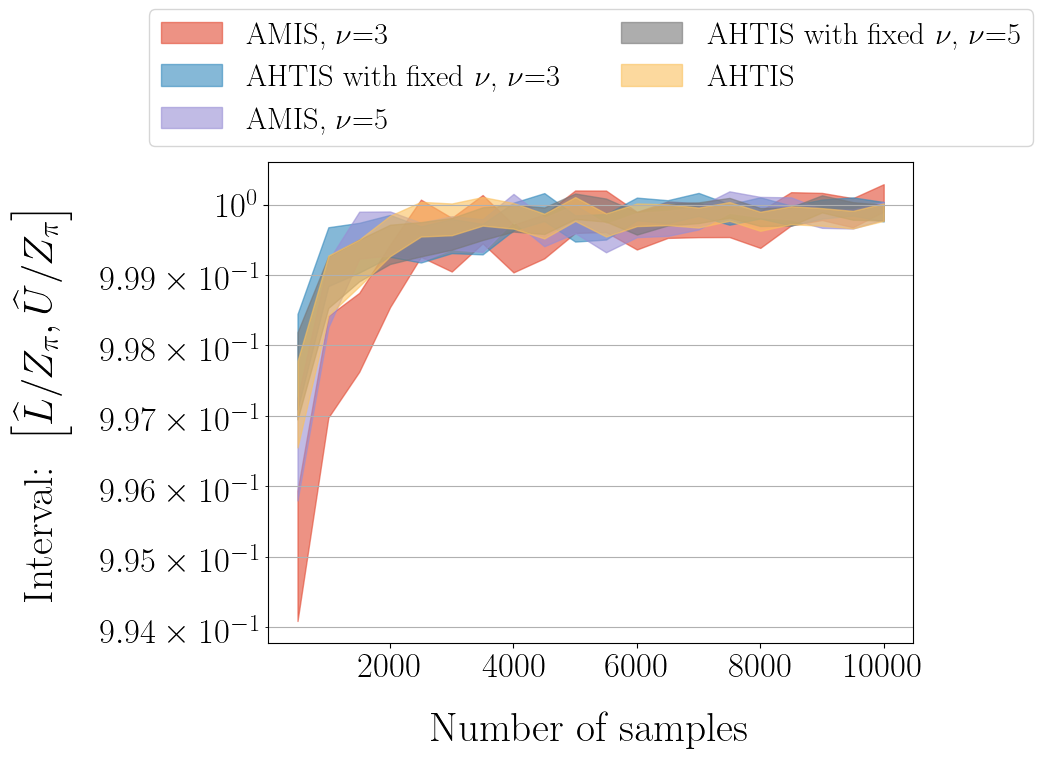

In [25]:
from scipy.stats import bootstrap
import itertools

# Define a list of strong colors and create a cycle
colors = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
color_cycle = itertools.cycle(colors)


fig = plt.figure()
fig.set_size_inches((1.3 * 6.4, 1.3 * 4.8))

# Best DOF it seems
truth_key = '100000'
truth_value = results_old_baseline['meanZ']['Laplaceinit']['5']['1000'][truth_key]

for dof in ['3','5']:

    sorted_numsamples_baseline = sorted(
        [
            int(key)
            for key, value in results_final_baseline['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)].items()
            if value is not None
        ]
    )
    sorted_numsamples_baseline_str = [str(num) for num in sorted_numsamples_baseline]

    sorted_numsamples_ours = sorted(
        [
            int(key)
            for key, value in results_final_ours['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)].items()
            if value is not None
        ]
    )

    sorted_numsamples_str = [str(num) for num in sorted_numsamples_ours] 



    # Step 2: Iterate through the sorted keys and get the corresponding values
    sorted_values_baseline = [results_final_baseline['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1] for key in sorted_numsamples_baseline_str]
    sorted_values_ours = [results_final_ours['allestZ']['Sigmfixedinit4'][dof][str(nb_runs)][key][:,-1] for key in sorted_numsamples_str]

    res_baseline = [
        (
            bootstrap_result.confidence_interval[0],
            bootstrap_result.confidence_interval[1]
        )
        for vals in sorted_values_baseline
        for bootstrap_result in [bootstrap((vals,), np.mean, confidence_level=0.9, random_state=np.random.default_rng())]
    ]
    
    res_ours = [
        (
            bootstrap_result.confidence_interval[0],
            bootstrap_result.confidence_interval[1]
        )
        for vals in sorted_values_ours
        for bootstrap_result in [bootstrap((vals,), np.mean, confidence_level=0.9, random_state=np.random.default_rng())]
    ] 
    

    # Use the next color in the cycle
    color = next(color_cycle)
    
    plt.fill_between(sorted_numsamples_baseline, [res[0]/truth_value for res in res_baseline], [res[1]/truth_value for res in res_baseline], alpha=0.6, color=color, label=r'AMIS, $\nu$={}'.format(dof),)

    # Use the next color in the cycle
    color = next(color_cycle)

    plt.fill_between(sorted_numsamples_ours, [res[0]/truth_value for res in res_ours], [res[1]/truth_value for res in res_ours], alpha=0.6, color=color, label=r'AHTIS with fixed $\nu$, $\nu$={}'.format(dof),)
    



sorted_values_ours_adapted = [results_final_ours_adapted['allestZ']['Sigmfixedinit4']['3'][str(nb_runs)][key][:,-1] for key in sorted_numsamples_baseline_str] # should be the same nsamples anyway

res_ours_adapted = [
    (
        bootstrap_result.confidence_interval[0],
        bootstrap_result.confidence_interval[1]
    )
    for vals in sorted_values_ours_adapted
    for bootstrap_result in [bootstrap((vals,), np.mean, confidence_level=0.9, random_state=np.random.default_rng())]
]

# Use the next color in the cycle
color = next(color_cycle)
plt.fill_between(sorted_numsamples_baseline, [res[0]/truth_value for res in res_ours_adapted], [res[1]/truth_value for res in res_ours_adapted], alpha=0.6, color=color, label='AHTIS',)


plt.xlabel('Number of samples')
plt.ylabel(r"$\text { Interval: }\left[\widehat{L} / Z_\pi, \widehat{U} / Z_\pi\right]$")
# plt.tight_layout()

plt.yscale('log')

plt.grid(axis='y',which='both')  # showing both major and minor grid lines

plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)

plt.savefig('./results/creatinine_bootstrap.pdf', bbox_inches='tight')


In [ ]:
# for dof in set_dofs:
#
#     sorted_numsamples_baseline = sorted(list(map(int, results_final_baseline['meanalphaESS']['Laplaceinit'][dof]['20000'].keys() )))
#
#     # sorted_numsamples_baseline = [x for x in sorted_numsamples_baseline if x in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]]
#
#     sorted_numsamples_baseline_str = [str(num) for num in sorted_numsamples_baseline]
#
#     # Step 2: Iterate through the sorted keys and get the corresponding values
#     sorted_values_baseline = [ results_final_baseline['meanalphaESS']['Laplaceinit'][dof]['20000'][key][0] for key in sorted_numsamples_baseline_str]
#     sorted_values_baseline_std = [ results_final_baseline['stdalphaESS']['Laplaceinit'][dof]['20000'][key][0] for key in sorted_numsamples_baseline_str]
#
#
#     sorted_numsamples_ours = sorted(list(map(int, results_final_ours['meanalphaESS']['Laplaceinit'][dof]['20000'].keys() )))
#     sorted_numsamples_ours = [x for x in sorted_numsamples_ours if x in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]]
#
#     sorted_numsamples_str = [str(num) for num in sorted_numsamples_ours] # should be the same as baseline right ?
#
#     # Step 2: Iterate through the sorted keys and get the corresponding values
#     sorted_values_ours = [ results_final_ours['meanalphaESS']['Laplaceinit'][dof]['20000'][key][0] for key in sorted_numsamples_str]
#     sorted_values_ours_std = [ results_final_ours['stdalphaESS']['Laplaceinit'][dof]['20000'][key][0] for key in sorted_numsamples_str]
#
#
#     sorted_values_baseline, sorted_values_ours, sorted_values_baseline_std, sorted_values_ours_std = np.array(sorted_values_baseline), np.array(sorted_values_ours), np.array(sorted_values_baseline_std), np.array(sorted_values_ours_std)
#
#     plt.plot(sorted_numsamples_baseline,  sorted_values_baseline, label='AMIS (\nu={})'.format(dof))
#     plt.plot(sorted_numsamples_ours,  sorted_values_ours, label='escort AMIS  (\nu={})'.format(dof))
#
#     plt.fill_between(sorted_numsamples_baseline, sorted_values_baseline - 1.96 * sorted_values_baseline_std, sorted_values_baseline + 1.96 * sorted_values_baseline_std, alpha=0.1)
#     plt.fill_between(sorted_numsamples_ours, sorted_values_ours - 1.96 * sorted_values_ours_std, sorted_values_ours + 1.96 * sorted_values_ours_std, alpha=0.1)
#
# plt.xlabel('Number of samples')
# plt.ylabel('alphaESS')
# # plt.axhline(y=truth, color='r', linestyle='solid', lw=2, label=r'AMIS with $10^5$ samples (dof=5)')
# plt.tight_layout()
# plt.legend()
# plt.yscale('log')
# plt.savefig('./results/creatinine_alphaESS.pdf',bbox_inches='tight')


In [ ]:
# for dof in set_dofs:
#
#     sorted_numsamples_baseline = sorted(list(map(int, results_final_baseline['meanZ']['Laplaceinit'][dof]['20000'].keys() )))
#
#     # Best DOF it seems
#     if dof == '5':
#         truth_key = str(sorted_numsamples_baseline[-1])
#         truth = results_final_baseline['meanZ']['Laplaceinit'][dof]['1000'][truth_key][0]
#
#     sorted_numsamples_baseline = [x for x in sorted_numsamples_baseline if x in [50, 100, 150, 200, 250]]
#
#     sorted_numsamples_baseline_str = [str(num) for num in sorted_numsamples_baseline]
#
#     # Step 2: Iterate through the sorted keys and get the corresponding values
#     sorted_values_baseline = [ results_final_baseline['meanZ']['Laplaceinit'][dof]['20000'][key][0] for key in sorted_numsamples_baseline_str]
#     sorted_values_baseline_std = [ results_final_baseline['stdZ']['Laplaceinit'][dof]['20000'][key][0] for key in sorted_numsamples_baseline_str]
#
#
#     sorted_numsamples_ours = sorted(list(map(int, results_final_ours['meanZ']['Laplaceinit'][dof]['20000'].keys() )))
#     sorted_numsamples_ours = [x for x in sorted_numsamples_ours if x in [50, 100, 150, 200, 250]]
#
#     sorted_numsamples_str = [str(num) for num in sorted_numsamples_ours] # should be the same as baseline right ?
#
#     # Step 2: Iterate through the sorted keys and get the corresponding values
#     sorted_values_ours = [ results_final_ours['meanZ']['Laplaceinit'][dof]['20000'][key][0] for key in sorted_numsamples_str]
#     sorted_values_ours_std = [ results_final_ours['stdZ']['Laplaceinit'][dof]['20000'][key][0] for key in sorted_numsamples_str]
#
#
#     sorted_values_baseline, sorted_values_ours, sorted_values_baseline_std, sorted_values_ours_std = np.array(sorted_values_baseline), np.array(sorted_values_ours), np.array(sorted_values_baseline_std), np.array(sorted_values_ours_std)
#
#     if dof == '5':
#         plt.plot(sorted_numsamples_baseline,  sorted_values_baseline, label='AMIS (\nu={})'.format(dof))
#         plt.plot(sorted_numsamples_ours,  sorted_values_ours, label='escort AMIS  (\nu={})'.format(dof))
#
#         plt.fill_between(sorted_numsamples_baseline, sorted_values_baseline -   sorted_values_baseline_std, sorted_values_baseline +   sorted_values_baseline_std, alpha=0.1)
#         plt.fill_between(sorted_numsamples_ours, sorted_values_ours -   sorted_values_ours_std, sorted_values_ours +   sorted_values_ours_std, alpha=0.1)
#
# plt.axhline(y=truth, color='r', linestyle='solid', lw=2, label='Estimated true value (with $10^5$ samples)')
# plt.xlabel('Number of samples')
# plt.ylabel(r'$\hat{Z} value$')
# plt.tight_layout()
# plt.yscale('log')
# plt.legend()
# plt.savefig('./results/creatinine_meanZ.pdf',bbox_inches='tight')


In [ ]:
# sorted_numsamples_baseline = sorted(list(map(int, results_baseline['meanalphaESSbaseline.npy'].keys())))
# sorted_numsamples_baseline_str = [str(num) for num in sorted_numsamples_baseline]
# # Step 2: Iterate through the sorted keys and get the corresponding values
# sorted_values_baseline = [ results_baseline['meanalphaESSbaseline.npy'][key] for key in sorted_numsamples_baseline_str]
#
# sorted_numsamples_ours = sorted(list(map(int, results_our_fixed_dof['25meanalphaESS.npy'].keys())))
# sorted_numsamples_ours_str = [str(num) for num in sorted_numsamples_ours]
# # Step 2: Iterate through the sorted keys and get the corresponding values
# sorted_values_ours = [ results_our_fixed_dof['25meanalphaESS.npy'][key] for key in sorted_numsamples_ours_str]
#
#
# plt.plot(sorted_numsamples_baseline[:len(sorted_numsamples_baseline) -  3],  sorted_values_baseline[:len(sorted_numsamples_baseline) -  3], label='AMIS (dof=3)')
# plt.plot(sorted_numsamples_ours[:len(sorted_numsamples_ours) -  3],  sorted_values_ours[:len(sorted_numsamples_ours) -  3], label='escort AMIS  (dof=3)')
# plt.xlabel('Number of samples')
# plt.ylabel('alphaESS')
# plt.legend()
# plt.savefig('./results/creatinine_alphaESS.pdf')


In [ ]:
# sorted_numsamples_baseline = sorted(list(map(int, results_baseline['25meanZbaseline.npy'].keys())))
# sorted_numsamples_baseline_str = [str(num) for num in sorted_numsamples_baseline]
# # Step 2: Iterate through the sorted keys and get the corresponding values
# sorted_values_baseline = [ results_baseline['25meanZbaseline.npy'][key] for key in sorted_numsamples_baseline_str]
#
# sorted_numsamples_ours = sorted(list(map(int, results_our_fixed_dof['25meanZ.npy'].keys())))
# sorted_numsamples_ours_str = [str(num) for num in sorted_numsamples_ours]
# # Step 2: Iterate through the sorted keys and get the corresponding values
# sorted_values_ours = [ results_our_fixed_dof['25meanZ.npy'][key] for key in sorted_numsamples_ours_str]
#
#
# plt.plot(sorted_numsamples_baseline[:len(sorted_numsamples_baseline) -  3],  sorted_values_baseline[:len(sorted_numsamples_baseline) -  3], label='AMIS (dof=3)')
# plt.plot(sorted_numsamples_ours[:len(sorted_numsamples_ours) -  3],  sorted_values_ours[:len(sorted_numsamples_ours) -  3], label='escort AMIS  (dof=3)')
# plt.axhline(y=sorted_values_ours[-1], color='r', linestyle='solid', lw=2, label='Estimated true value (with 6e+4 samples)')
#
# plt.xlabel('Number of samples')
# plt.ylabel('mean Z value')
# plt.legend()
# plt.savefig('./results/creatinine_meanZ_estimation.pdf')

###  results

In [ ]:
# print('Estimate by AMIS', mean_Z_baseline[-1], std_Z_baseline[-1])
# print('Estimate by alpha AMIS', mean_Z[-1], std_Z[-1])
#


In [ ]:
# print('ESS by AMIS', mean_ESS_baseline[-1], 1.96* std_ESS_baseline[-1])
# print('alpha ESS by AMIS', mean_alphaESS_baseline[-1], 1.96*std_alphaESS_baseline[-1])
# print('ESS by escort moment AMIS', mean_ESS[-1], 1.96*std_ESS[-1])
# print('alpha ESS by by escort moment AMIS', mean_alphaESS[-1], 1.96* std_alphaESS[-1])


### Old: comparison with MCMC via KSD

In [ ]:
# def numpy_callback(x):
#   # Need to forward-declare the shape & dtype of the expected output.
#   result_shape = jax.core.ShapedArray(x.shape, x.dtype)
#   return jax.pure_callback(np.sin, result_shape, x)

def log_density_gradient_correct(theta):
    return bridgestan_model.log_density_gradient(theta)[1]

def log_density_gradient(theta):
    result_shape = jax.core.ShapedArray(theta.shape , theta.dtype)
    # _, gradient = bridgestan_model.log_density_gradient(theta)
    gradient = jax.experimental.io_callback(log_density_gradient_correct, result_shape, theta)
    return gradient

In [ ]:
jax.config.update("jax_enable_x64", True)
# compare results with MCMC via the KSD
ksd_mcmc_samples = old_ksd(mcmc_samples_array, log_density_gradient)
print("KSD using true samples:", ksd_mcmc_samples)



In [ ]:
from scipy.special import logsumexp

final_samples = adapted_proposal.rvs(size=50000)

weights = bridgestan_model.log_density(final_samples) - adapted_proposal.logpdf(final_samples)
normalized_weights = np.exp(weights - logsumexp(weights))
ksd_fixed_dof = old_ksd(final_samples, log_density_gradient, weights=normalized_weights)
print("KSD for adapted proposal samples:", ksd_fixed_dof)
